# Initialisation

In [3]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
from numpy import ravel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr

# TP1

# Ajout du Dataset

In [6]:
features = pd.read_csv('acsincome_ca_features.csv')

In [7]:
labels = pd.read_csv('acsincome_ca_labels.csv')

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

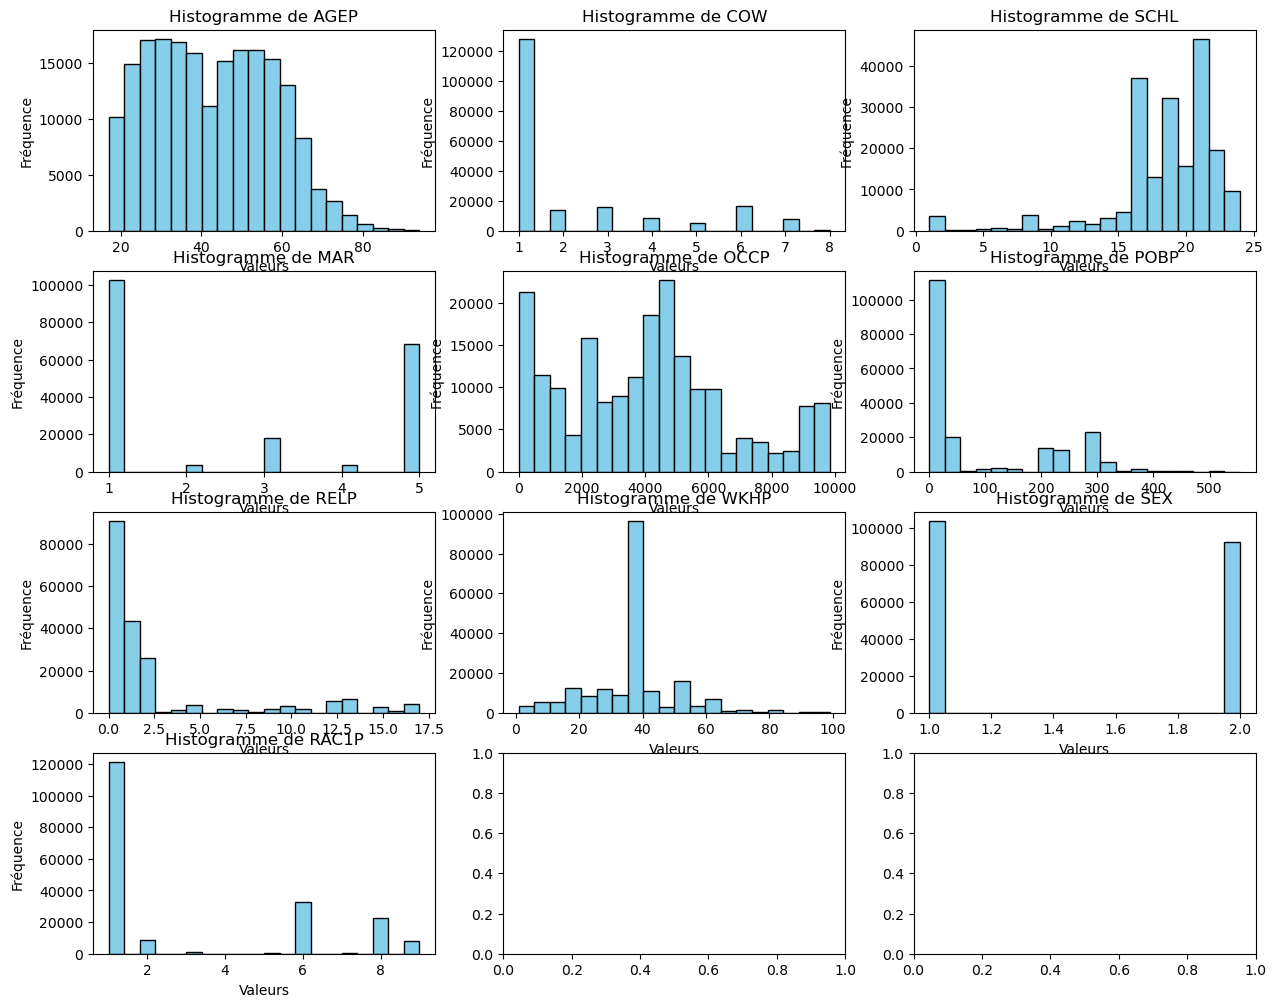

In [8]:
dataset = pd.concat([features, labels], axis=1)
#dataset.hist(figsize=(12, 10))
# Définir la taille de la figure et le nombre de colonnes pour les sous-plots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))

# Afficher les histogrammes pour chaque feature dans des sous-plots séparés
for i, column in enumerate(dataset.columns):
    ax = axes.flatten()[i]
    ax.hist(dataset[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogramme de {column}')
    ax.grid(False)
    ax.set_xlabel('Valeurs')
    ax.set_ylabel('Fréquence')

# Ajuster l'espacement entre les sous-plots et montrer la figure
plt.tight_layout()
plt.show()

# Standardisation des données

In [12]:
scaler = StandardScaler()

fit_features = scaler.fit_transform(features)
fit_labels = scaler.fit_transform(labels)

# Shuffeling

In [13]:
# Mélanger les indices
indices = shuffle(range(len(features)), random_state=1)

# Utiliser les indices mélangés pour obtenir les nouvelles versions de X_all et y_all
X_all = features.iloc[indices]
y_all = labels.iloc[indices]

# only use the first N samples to limit training time
num_samples = int(len(X_all) * 0.1)
X, y = X_all.iloc[:num_samples], y_all.iloc[:num_samples]

# Subdivising

In [14]:
# Divisez les données en un ensemble d'entraînement (80%) et un ensemble de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichez la taille des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))


Taille de l'ensemble d'entraînement : 15652
Taille de l'ensemble de test : 3914


# Cross Validation

In [15]:
# Créer une liste de modèles
models = [
    ("SVM", SVC()),
    ("Adaboost", AdaBoostClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("RandomForest", RandomForestClassifier())
]

# Boucle sur les modèles
for name, model in models:
    # Aplatir la cible y_train
    y_train_flattened = ravel(y_train)
    
    # Effectuer une cross-validation
    scores = cross_val_score(model, X_train, y_train_flattened, cv=5)
    print(f"{name}: Mean Accuracy: {scores.mean()}, Standard Deviation: {scores.std()}")
    

SVM: Mean Accuracy: 0.7009974867423876, Standard Deviation: 0.008393773338481389
Adaboost: Mean Accuracy: 0.8071812433227246, Standard Deviation: 0.01055795089617608
GradientBoosting: Mean Accuracy: 0.8101839280083837, Standard Deviation: 0.008656930433518005
RandomForest: Mean Accuracy: 0.8027726241654362, Standard Deviation: 0.012170545117487804


# Evaluation

In [8]:
for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model

    model_instance.fit(X_train, y_train_flattened)

   
    y_pred = model_instance.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")  # Juste une séparation visuelle entre les résultats des différents modèles


Evaluation results for SVM:
Accuracy: 0.7077158916709249
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.82      0.77      2326
        True       0.68      0.54      0.60      1588

    accuracy                           0.71      3914
   macro avg       0.70      0.68      0.68      3914
weighted avg       0.70      0.71      0.70      3914

Confusion Matrix:
 [[1917  409]
 [ 735  853]]


Evaluation results for Adaboost:
Accuracy: 0.8078691875319366
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.84      0.84      2326
        True       0.77      0.76      0.76      1588

    accuracy                           0.81      3914
   macro avg       0.80      0.80      0.80      3914
weighted avg       0.81      0.81      0.81      3914

Confusion Matrix:
 [[1963  363]
 [ 389 1199]]


Evaluation results for GradientBoosting:
Accuracy: 0.8117015840572305
Classificatio

**SVM** 
Nous avons testé tous les différents kernels disponibles. Cependant, les kernels Linear et Precomputed n'ont pas l'air de fonctionner.

In [9]:
# Définir les hyperparamètres que vous souhaitez rechercher pour chaque modèle
param_grid = {
    'SVM' :{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['rbf','poly','sigmoid']},
    'Adaboost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

# Boucle sur les modèles et effectuer la recherche des hyperparamètres
for name, model in models:
    if name in param_grid:
        y_train_flattened = ravel(y_train)
        grid_search = GridSearchCV(model, param_grid[name], cv=5)
        grid_search.fit(X_train, y_train_flattened)
        print(name)
        print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_}")
        print("\n")


SVM
Best hyperparameters for SVM: {'C': 1000, 'kernel': 'rbf'}
Best cross-validation score: 0.7672503859682063


Adaboost
Best hyperparameters for Adaboost: {'learning_rate': 1, 'n_estimators': 200}
Best cross-validation score: 0.814336445908839


GradientBoosting
Best hyperparameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation score: 0.8159976653132694


RandomForest
Best hyperparameters for RandomForest: {'max_depth': 10, 'n_estimators': 200}
Best cross-validation score: 0.8106311307210283




# Test sur les données

In [10]:
# Créer une liste de modèles
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

# Boucle sur les modèles
for name, model in models:
    y_train_flattened = ravel(y_train)
    # Effectuer une cross-validation
    scores = cross_val_score(model, X_train, y_train_flattened, cv=5)
    print(f"{name}: Mean Accuracy: {scores.mean()}, Standard Deviation: {scores.std()}")

for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model

    model_instance.fit(X_train, y_train_flattened)


    y_pred = model_instance.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")

SVM: Mean Accuracy: 0.7672503859682063, Standard Deviation: 0.008866186589166705
Adaboost: Mean Accuracy: 0.814336445908839, Standard Deviation: 0.009927827285828375
GradientBoosting: Mean Accuracy: 0.816061542668747, Standard Deviation: 0.008859359763865865
RandomForest: Mean Accuracy: 0.8098643779661898, Standard Deviation: 0.010819182715637282
Evaluation results for SVM:
Accuracy: 0.771078180889116
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.84      0.81      2326
        True       0.74      0.67      0.70      1588

    accuracy                           0.77      3914
   macro avg       0.76      0.75      0.76      3914
weighted avg       0.77      0.77      0.77      3914

Confusion Matrix:
 [[1955  371]
 [ 525 1063]]


Evaluation results for Adaboost:
Accuracy: 0.8140010219724068
Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.85      0.84      2326
 

    Faire shuffle puis echantillonage et puis enfin standardscaling

# Test des models sur autres datasets

In [54]:
nevada_features = pd.read_csv('./TP2_data/acsincome_ne_allfeaturesTP2.csv')
nevada_labels = pd.read_csv('./TP2_data/acsincome_ne_labelTP2.csv')

colorado_features = pd.read_csv('./TP2_data/acsincome_ne_allfeaturesTP2.csv')
colorado_labels =pd.read_csv('./TP2_data/acsincome_ne_labelTP2.csv')

In [55]:
# Mélanger les indices
indices_co = shuffle(range(len(colorado_features)), random_state=1)
indices_ne = shuffle(range(len(nevada_features)), random_state=1)

# Utiliser les indices mélangés pour obtenir les nouvelles versions de X_all et y_all
X_all_co = colorado_features.iloc[indices_co]
y_all_co = colorado_labels.iloc[indices_co]

X_all_ne = nevada_features.iloc[indices_ne]
y_all_ne = nevada_labels.iloc[indices_ne]

# only use the first N samples to limit training time
num_samples_co = int(len(X_all_co) * 0.01)
num_samples_ne = int(len(X_all_ne) * 0.01)
X_co, y_co = X_all_co.iloc[:num_samples_co], y_all_co.iloc[:num_samples_co]
X_ne, y_ne = X_all_ne.iloc[:num_samples_ne], y_all_ne.iloc[:num_samples_ne]

## Nevada

In [56]:
models = [
    ("SVM", SVC(C = 1000, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model.fit(X_train, y_train_flattened)
    
    y_pred = model.predict(X_ne)


    accuracy = accuracy_score(y_ne, y_pred)
    report = classification_report(y_ne, y_pred)
    conf_matrix = confusion_matrix(y_ne, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")

Evaluation results for SVM:
Accuracy: 0.7383177570093458
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.78        64
           1       0.68      0.65      0.67        43

    accuracy                           0.74       107
   macro avg       0.73      0.72      0.73       107
weighted avg       0.74      0.74      0.74       107

Confusion Matrix:
 [[51 13]
 [15 28]]


Evaluation results for Adaboost:
Accuracy: 0.7289719626168224
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75        64
           1       0.63      0.79      0.70        43

    accuracy                           0.73       107
   macro avg       0.73      0.74      0.73       107
weighted avg       0.75      0.73      0.73       107

Confusion Matrix:
 [[44 20]
 [ 9 34]]


Evaluation results for GradientBoosting:
Accuracy: 0.7570093457943925
Classification Report:
      

## Colorado

In [57]:
models = [
    ("SVM", SVC(C = 1000, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model.fit(X_train, y_train_flattened)
    
    y_pred = model.predict(X_co)


    accuracy = accuracy_score(y_co, y_pred)
    report = classification_report(y_co, y_pred)
    conf_matrix = confusion_matrix(y_co, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")

Evaluation results for SVM:
Accuracy: 0.7383177570093458
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.78        64
           1       0.68      0.65      0.67        43

    accuracy                           0.74       107
   macro avg       0.73      0.72      0.73       107
weighted avg       0.74      0.74      0.74       107

Confusion Matrix:
 [[51 13]
 [15 28]]


Evaluation results for Adaboost:
Accuracy: 0.7289719626168224
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75        64
           1       0.63      0.79      0.70        43

    accuracy                           0.73       107
   macro avg       0.73      0.74      0.73       107
weighted avg       0.75      0.73      0.73       107

Confusion Matrix:
 [[44 20]
 [ 9 34]]


Evaluation results for GradientBoosting:
Accuracy: 0.7570093457943925
Classification Report:
      

# -----------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------------

# TP2

# Calcul de correlation 

In [142]:
noms_features = features.columns.tolist()
corr_coef = []
for feat in noms_features:
    correlation_coefficient = pearsonr(X_train[feat], y_train)
    corr_coef.append(correlation_coefficient[0][0])
    print(feat + " : " + str(correlation_coefficient[0][0]))

AGEP : 0.2625629832904517
COW : 0.05661628512750293
SCHL : 0.33965610681309416
MAR : -0.2866702542897235
OCCP : -0.34049768774736
POBP : -0.08322858734338258
RELP : -0.23075703768928618
WKHP : 0.3392247594394883
SEX : -0.11965047403799021
RAC1P : -0.10601229794741156


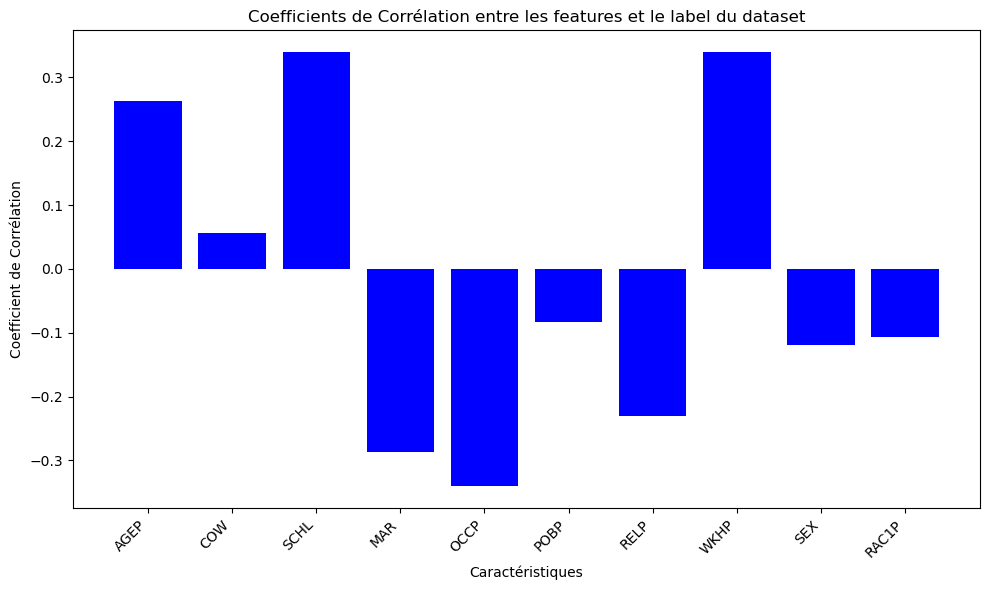

In [147]:
# Créer l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(noms_features, corr_coef, color='blue')
plt.xlabel('Caractéristiques')
plt.ylabel('Coefficient de Corrélation')
plt.title('Coefficients de Corrélation entre les features et le label du dataset')
plt.xticks(rotation=45, ha='right')  # Pour faire pivoter les noms des caractéristiques
plt.tight_layout()

# Afficher l'histogramme
plt.show()

In [130]:
# Créer une liste de modèles
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model
    model_instance.fit(X_train, y_train_flattened)
    if name == "SVM":
        y_pred_SVM = model_instance.predict(X_train)
    if name == "Adaboost":
        y_pred_Adaboost = model_instance.predict(X_train)
    if name == "GradientBoosting":
        y_pred_GradientBoosting = model_instance.predict(X_train)
    if name == "RandomForest":
        y_pred_RandomForest = model_instance.predict(X_train)

In [152]:
noms_features = features.columns.tolist()
y_list = [y_pred_SVM, y_pred_Adaboost, y_pred_GradientBoosting, y_pred_RandomForest]
n = 0
SVM_corr = []
Adaboost_corr = []
GradientBoosting_corr = []
RandomForest_corr = []
for y in y_list:
    for feat in noms_features:
        correlation_coefficient = pearsonr(X_train[feat], y)
        print(feat + " : " + str(correlation_coefficient.statistic))
        if n == 0:
            SVM_corr.append(correlation_coefficient.statistic)
        if n == 1:
            Adaboost_corr.append(correlation_coefficient.statistic)
        if n == 2:
            GradientBoosting_corr.append(correlation_coefficient.statistic)
        if n == 3:
            RandomForest_corr.append(correlation_coefficient.statistic)
    print("\n")
    n +=1
Model_corr = [SVM_corr, Adaboost_corr, GradientBoosting_corr, RandomForest_corr]

AGEP : 0.13564474688821634
COW : 0.07529920425985566
SCHL : 0.37157062795747703
MAR : -0.1494973761369007
OCCP : -0.7758866552522292
POBP : -0.11062258014675645
RELP : -0.13517279611187177
WKHP : 0.19910968991674355
SEX : -0.022324660027756887
RAC1P : -0.10012903706682795


AGEP : 0.2892825189688337
COW : 0.06872310165237545
SCHL : 0.44064848811336443
MAR : -0.3283828785544695
OCCP : -0.4510864817345751
POBP : -0.1243566824282959
RELP : -0.2750096518105684
WKHP : 0.4092662296128753
SEX : -0.15272015509656264
RAC1P : -0.13456527724067335


AGEP : 0.29192169332087703
COW : 0.08014621878635889
SCHL : 0.4469827330888051
MAR : -0.32787451043252414
OCCP : -0.4626219927929106
POBP : -0.1234822860268235
RELP : -0.28238374448573744
WKHP : 0.407877469572392
SEX : -0.13593872480379643
RAC1P : -0.14080885131808804


AGEP : 0.27535473499773105
COW : 0.0974912462741075
SCHL : 0.4537038173155715
MAR : -0.3251278336619948
OCCP : -0.4730553723424907
POBP : -0.12241327742532905
RELP : -0.277162786542724

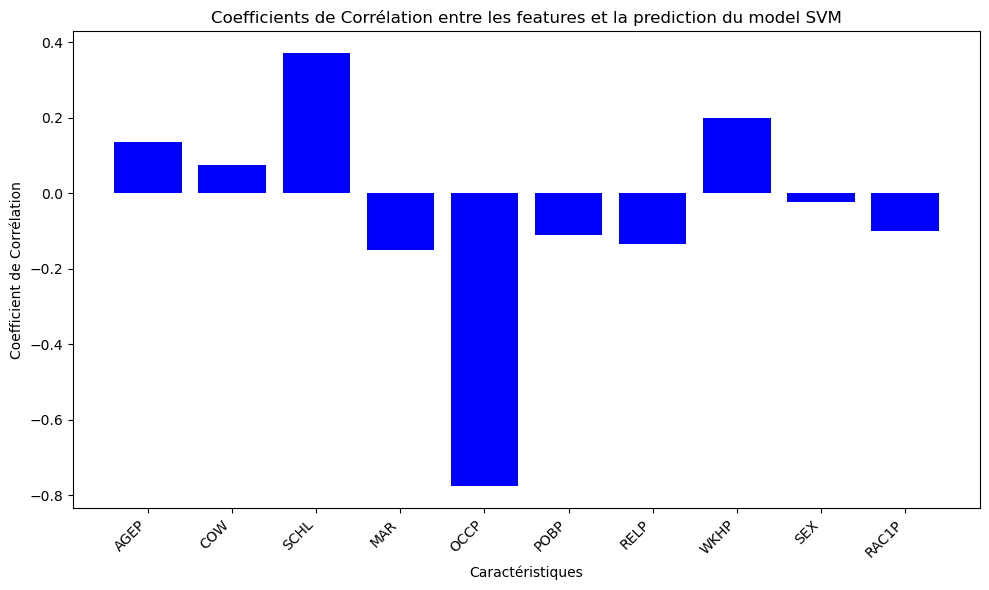

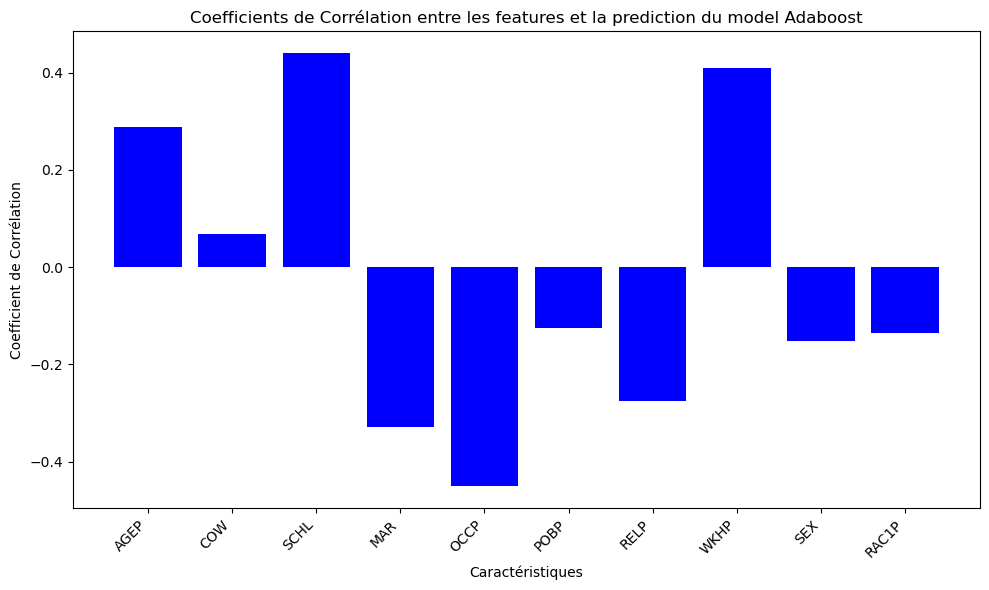

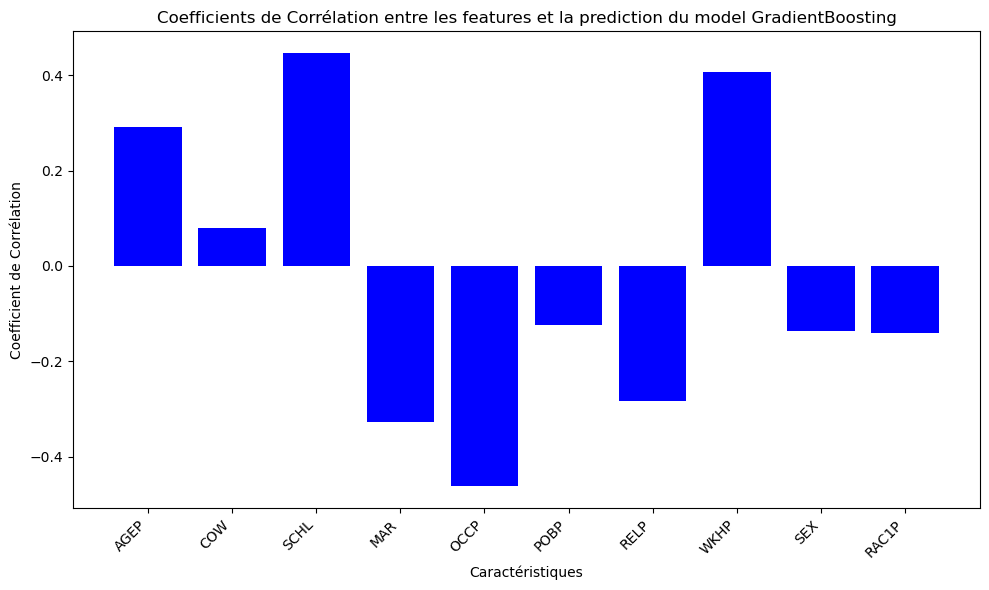

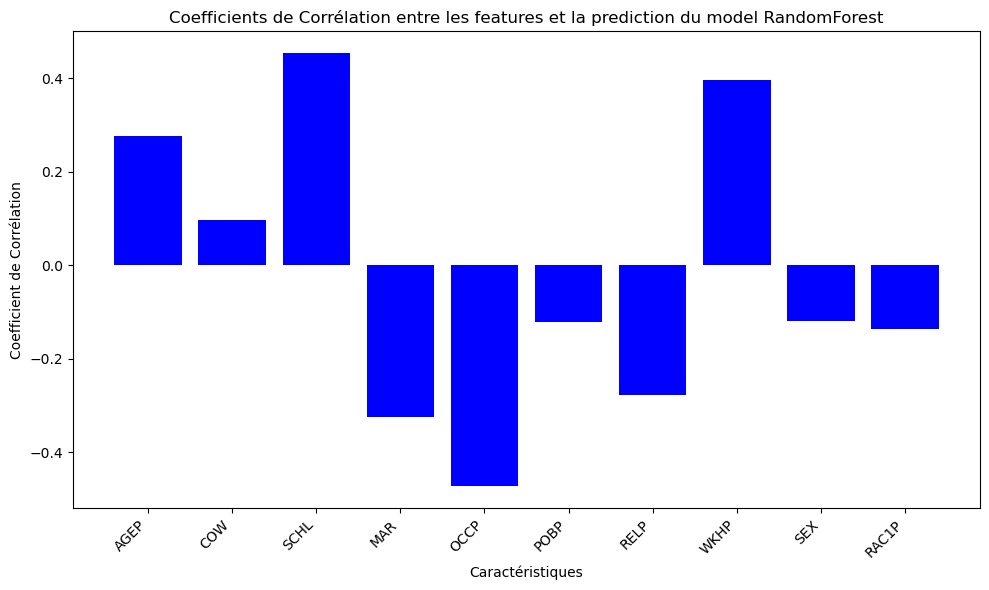

In [157]:
n = 0
for name, model in models:
    # Créer l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(noms_features, Model_corr[n], color='blue')
    plt.xlabel('Caractéristiques')
    plt.ylabel('Coefficient de Corrélation')
    plt.title('Coefficients de Corrélation entre les features et la prediction du model ' + name )
    plt.xticks(rotation=45, ha='right')  # Pour faire pivoter les noms des caractéristiques
    plt.tight_layout()

    # Afficher l'histogramme
    plt.show()
    n += 1

In [135]:
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model
    model_instance.fit(X_train, y_train_flattened)
    if name == "SVM":
        result_SVM = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    if name == "Adaboost":
        result_Adaboost = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    if name == "GradientBoosting":
        result_GradientBoosting = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    if name == "RandomForest":
        result_RandomForest = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

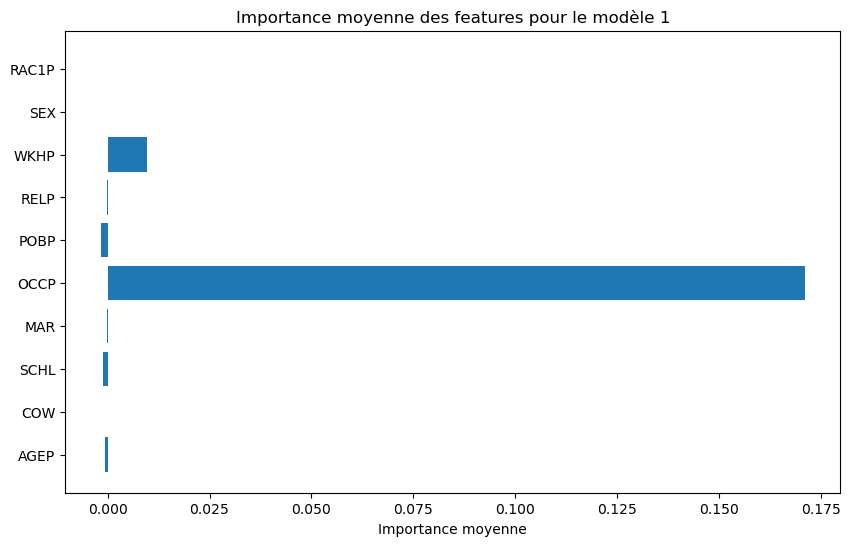

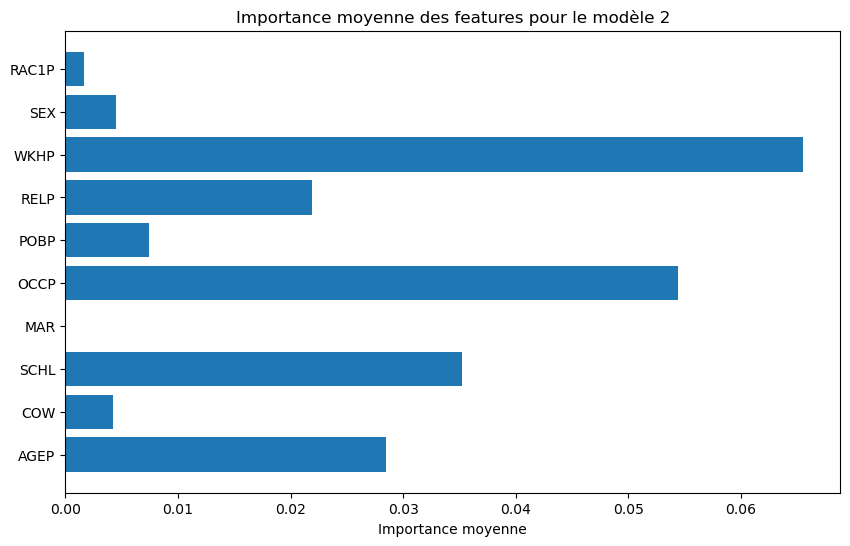

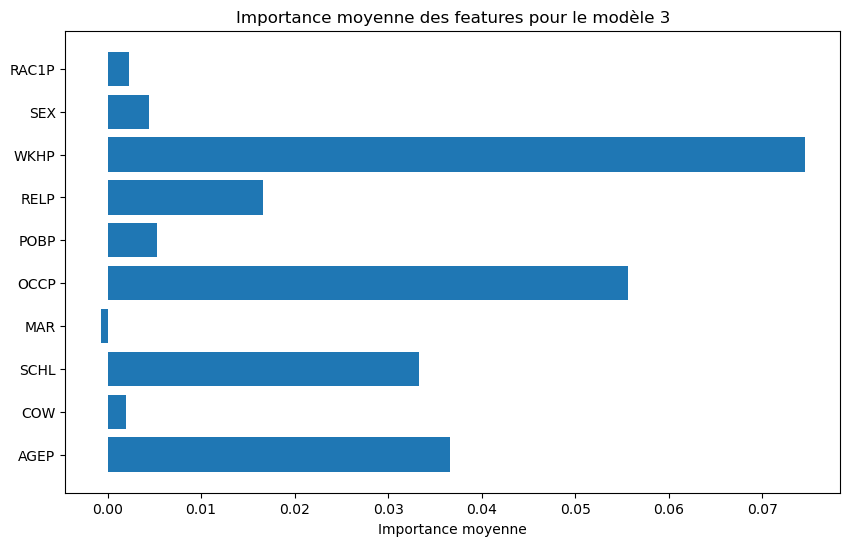

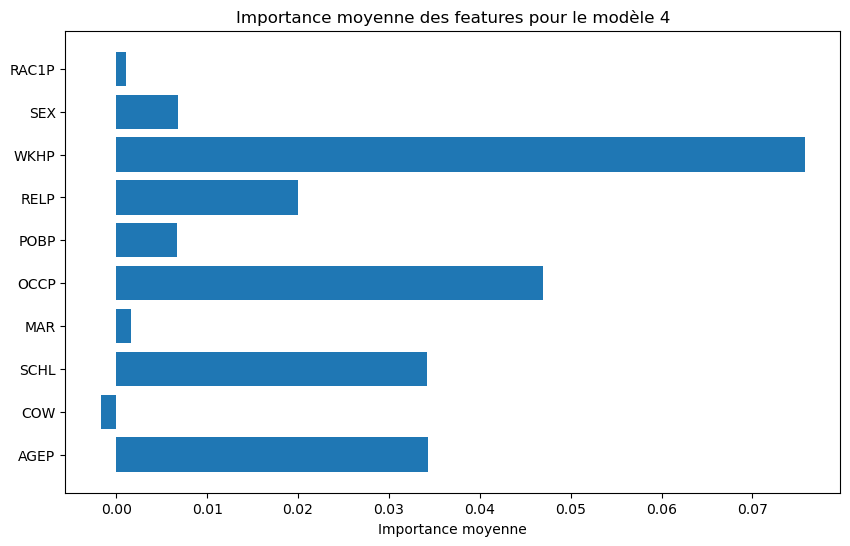

In [159]:
result_list = [result_SVM, result_Adaboost, result_GradientBoosting, result_RandomForest]
result_list[0]['importances_mean']

feature_names = features.columns
for idx, result in enumerate(result_list):
    importance_means = result['importances_mean']

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_means)), importance_means, align='center')
    plt.yticks(range(len(importance_means)), feature_names)
    plt.xlabel('Importance moyenne')
    plt.title(f'Importance moyenne des features pour le modèle {idx + 1}')
    plt.show()

# Matrice de confusion de la feature 'SEX' pour les différents modèles

In [25]:
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]
feature = 'SEX'

diff_valeur = features[feature].unique()

for name, model in models:
    for i in diff_valeur:
        y_train_flattened = ravel(y_train)
        model_instance = model
        model_instance.fit(X_train, y_train_flattened)
        
        y_pred = model_instance.predict(X_test)
        mask = (X_test[feature] == i)
        conf_matrix = confusion_matrix(y_test[mask], y_pred[mask])
        
        print(f"Confusion matrix for {feature} using {name} for value of {int(i)}:")
        print(conf_matrix)
        print("\n" + "="*50 + "\n")


Confusion matrix for SEX using SVM for value of 1:
[[944 180]
 [410 509]]


Confusion matrix for SEX using SVM for value of 2:
[[964 238]
 [281 388]]


Confusion matrix for SEX using Adaboost for value of 1:
[[915 209]
 [177 742]]


Confusion matrix for SEX using Adaboost for value of 2:
[[1060  142]
 [ 200  469]]


Confusion matrix for SEX using GradientBoosting for value of 1:
[[923 201]
 [185 734]]


Confusion matrix for SEX using GradientBoosting for value of 2:
[[1054  148]
 [ 189  480]]


Confusion matrix for SEX using RandomForest for value of 1:
[[932 192]
 [206 713]]


Confusion matrix for SEX using RandomForest for value of 2:
[[1047  155]
 [ 193  476]]


